# MODEL

In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import enum

import os
from PIL import Image
import cv2 #pip install opencv-python
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
import torchvision
import copy
import sklearn.metrics
import time
import torch.utils
import torch.utils.data
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Reeee

In [2]:
import import_ipynb
# import proeprocess
%run preprocess.ipynb
%run stinna.ipynb

In [3]:
simple_transformer = transforms.Compose([
        transforms.ToTensor()])

Split data into train set, validation set and test set with ratio 80/10/10

In [22]:
# import splitfolders
# splitfolders.ratio(PATHbirdsWithBackground, output="output",seed=42, ratio=(0.8,0.1,0.1) )

Set up paths to data and dataloaders for traning set and validation set

In [4]:
PATH_TEST = "split_withbackground/test"
test_set = datasets.ImageFolder(PATH_TEST, simple_transformer)

PATH_TRAIN = "split_withbackground/train"
train_set = datasets.ImageFolder(PATH_TRAIN, simple_transformer)

PATH_VAL = "split_withbackground/val"
val_set = datasets.ImageFolder(PATH_VAL, simple_transformer)
class_labels = val_set.classes
print('Labels: {}'.format(class_labels))

dataset_size_train = len(train_set)
dataset_size_val = len(val_set)
print('No of images in training set: {}'.format(dataset_size_train))
print('No of images in validation set: {}'.format(dataset_size_val))

Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
No of images in training set: 835
No of images in validation set: 104


In [5]:
dataloader_train = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
dataloader_validation = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4)

In [6]:
%matplotlib inline

In [7]:
# taken from Lab 5
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a random batch of training data
# inputs, classes = next(iter(dataloader_train))

# Make a grid of images
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[train_set.classes[x] for x in classes])

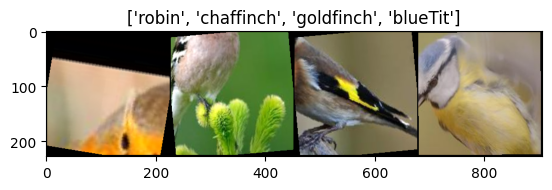

In [30]:
# From lab 5
# Data augmentation transformer
# augmentation_transformer = transforms.Compose([
#         transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio
#         transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
#         transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
#         transforms.RandomRotation(degrees=10), # Rotate the image by angle.
#         transforms.ToTensor()])

# # Same as above, expect that we are using augmentation_transformer instead of simple_transformer
# train_set = datasets.ImageFolder(PATH_TRAIN, augmentation_transformer)
# dataloader_aug = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
# inputs, classes = next(iter(dataloader_aug))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[train_set.classes[x] for x in classes])

In [8]:
inputs, classes = next(iter(dataloader_train))

In [9]:
print(classes)

tensor([1, 6, 1, 4])


Import ResNet50 model with the pretrained weights  
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50

In [19]:
pretrained_weigths = models.ResNet50_Weights.DEFAULT
def load_model(weigths = pretrained_weigths):
    model = resnet50(weights=weigths)
    print(model)
    #Replace last layer to match 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    print(model.fc)
    return model
model = load_model()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
# Initialize the inference transforms
preprocess = pretrained_weigths.transforms()
# dont know if we need

Inference transforms perform the following preprocessing operations:  
- Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.  
- The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224].  
- Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Put the pedal to the medal and use GPU

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, optimizer, num_epoch=25, batch_size=5):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    best_acc = 0.0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader_train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train)
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in dataloader_validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val)
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_model_weight = copy.deepcopy(model.state_dict())
        
        time_epoch_val = time.time() - since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Validation accuracies:")
    print(acc_validation)
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation}
    model.load_state_dict(best_model_weight)
    return model, data


In [22]:
# Freeze all layers (i.e., disable training so we dont start from scratch)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc) s.t. we only train that to get a better starting point for fine tuning
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

#Use stochastic gradient descent and optimize parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [14]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure().set_figwidth(12)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_validation):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(val_set.classes[preds[j]],
                                                       val_set.classes[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
trained, data = train_model(model=model,optimizer=optimizer, num_epoch=2) #took like 4 minutes on device

Epoch 1/2
----------
Train Loss: 1.6634 Acc: 0.5988
Val Loss: 1.2844 Acc: 0.9423
Epoch time 1m 49s
----------

Epoch 2/2
----------
Train Loss: 1.2189 Acc: 0.8108
Val Loss: 0.9498 Acc: 0.8846
Epoch time 3m 42s
----------

Training complete in 3m 42s
Validation accuracies:
[tensor(0.9423, dtype=torch.float64), tensor(0.8846, dtype=torch.float64)]


In [ ]:
visualize_model(trained)

In [ ]:
model = trained
# Unfreeze all layers such that we can fine-tune the model
for param in model.parameters():
    param.requires_grad = True

model, data = train_model(model, optimizer, num_epoch=4) #took like 24 min

Epoch 1/4
----------
Train Loss: 0.5981 Acc: 0.8838
Val Loss: 0.1496 Acc: 0.9712
Epoch time 4m 54s
----------

Epoch 2/4
----------
Train Loss: 0.1948 Acc: 0.9461
Val Loss: 0.1149 Acc: 0.9712
Epoch time 9m 53s
----------

Epoch 3/4
----------


In [ ]:
# visualize_model(model)

# # plt.ioff()
# # plt.ion()
# plt.show()

In [ ]:
def makeAll(dataloader):
    '''
    Gets all labels and predictions for the imgages in the dataloader 
    '''
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    print("hello world")
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
    return lbllist, predlist

In [ ]:
%run stinna.ipynb

truel, predl = makeAll(dataloader_validation)
truel, predl = truel.numpy(), predl.numpy()

plot_confusion_matrix(truel, predl, class_labels)

In [ ]:
plot_confusion_matrix(truel, predl, class_labels)

In [ ]:
plot_accuracies(data["train_acc"], data["val_acc"])